In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_files = pd.read_csv('/content/drive/MyDrive/Smart Bridge project/train/train.csv')
train_files.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
ship = { 1:'Cargo',
2 : 'Military',
 3 : 'Carrier',
 4 : 'Cruise',
5  : 'Tankers'}

In [5]:
train_files['ship'] = train_files['category'].map(ship).astype('category')

In [6]:
train_files.head()

,image,category,ship
0,2823080.jpg,1,Cargo
1,2870024.jpg,1,Cargo
2,2662125.jpg,2,Military
3,2900420.jpg,3,Carrier
4,2804883.jpg,2,Military


In [9]:
labels = train_files.sort_values('ship')
class_names = list(labels.ship.unique())
for i in class_names:
  os.makedirs(os.path.join('/content/drive/MyDrive/Smart Bridge project/Ship Classfication/input/train',i))

In [10]:
import shutil
for c in class_names:
  for i in list(labels[labels['ship']==c]['image']):
    get_image = os.path.join('/content/drive/MyDrive/Smart Bridge project/train/images/',i)
    put_image = os.path.join('/content/drive/MyDrive/Smart Bridge project/Ship Classfication/input/train/',c)
    shutil.move(get_image,put_image)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input

In [12]:
train_datagen = ImageDataGenerator(rotation_range=45,
                                   horizontal_flip=True,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   validation_split=0.2,
                                   preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Smart Bridge project/Ship Classfication/input/train/',
                                              batch_size=16,subset='training',
                                              target_size = (224,224))

validation_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Smart Bridge project/Ship Classfication/input/train/',
                                              batch_size=16,subset='validation',
                                              target_size = (224,224))

# test_set = test_datagen.flow_from_directory('',
#                                               batch_size=16,
#                                               target_size = (224,224))

Found 5003 images belonging to 5 classes.
Found 1249 images belonging to 5 classes.


In [27]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import DepthwiseConv2D, SeparableConv2D, AveragePooling2D, Flatten, Dense, Input, GlobalAveragePooling2D


In [ ]:
def create_model(input_shape, n_classes):
    model = Sequential([
        Input(shape=input_shape),  # Input shape (Height, Width, Channels)

        DepthwiseConv2D(kernel_size=3, strides=1, padding="same", activation="relu"),  # Extract spatial features
        SeparableConv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu"),  # Efficient feature extraction
        AveragePooling2D(pool_size=2, strides=2),  # Reduce spatial dimensions
        # tf.keras.layers.Dropout(0.5),
        DepthwiseConv2D(kernel_size=3, strides=1, padding="same", activation="relu"),
        SeparableConv2D(filters=64, kernel_size=3, strides=1, padding="same", activation="relu"),
        AveragePooling2D(pool_size=2, strides=2),
        tf.keras.layers.Dropout(0.5),
        DepthwiseConv2D(kernel_size=3, strides=1, padding="same", activation="relu"),
        SeparableConv2D(filters=128, kernel_size=3, strides=1, padding="same", activation="relu"),
        AveragePooling2D(pool_size=2, strides=2),
        GlobalAveragePooling2D(),

        Flatten(),  # Flatten before passing to Dense layers
        Dense(128, activation="relu"),  # Fully connected layer
        Dense(n_classes, activation="softmax")  # Output layer for classification (10 classes)
    ])

    # Compile model
    model.compile(optimizer="adam",
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

    return model


In [49]:
strategy = tf.distribute.MirroredStrategy()
strategy.num_replicas_in_sync

1

In [57]:
from tensorflow.keras.optimizers import Adam

imput_shape = (224,224,3)
optim = Adam(learning_rate=0.0001)
model = create_model(imput_shape,5)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ depthwise_conv2d_12             │ (None, 224, 224, 3)    │            30 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_12             │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_12            │ (None, 112, 112, 32)   │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_13             │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_13             │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_13            │ (None, 56, 56, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_14             │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_14             │ (None, 56, 56, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_14            │ (None, 28, 28, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,598 (115.62 KB)

 Trainable params: 29,598 (115.62 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
import tensorflow as tf

In [53]:
history = model.fit(train_set,
                    validation_data=validation_set,
                    epochs=35)


Epoch 1/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 310ms/step - accuracy: 0.4082 - loss: 1.3806 - val_accuracy: 0.4211 - val_loss: 1.3656
Epoch 2/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 310ms/step - accuracy: 0.4321 - loss: 1.3490 - val_accuracy: 0.3955 - val_loss: 1.4197
Epoch 3/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 311ms/step - accuracy: 0.4364 - loss: 1.3196 - val_accuracy: 0.4251 - val_loss: 1.3524
Epoch 4/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 307ms/step - accuracy: 0.4546 - loss: 1.2898 - val_accuracy: 0.4572 - val_loss: 1.3150
Epoch 5/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 309ms/step - accuracy: 0.4941 - loss: 1.2496 - val_accuracy: 0.4115 - val_loss: 1.4338
Epoch 6/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 97s 309ms/step - accuracy: 0.4943 - loss: 1.2301 - val_accuracy: 0.4412 - val_loss: 1.3704
Epoch 7/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 311ms/step - accuracy: 0.4994 - loss: 1.2181 - val_accuracy: 0.4828 - val_loss: 1.2220
Epoch 8/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 142s 310ms/step - accuracy: 0.5170 - loss

In [54]:

model.save('my_h5_model2.h5', save_format='h5')

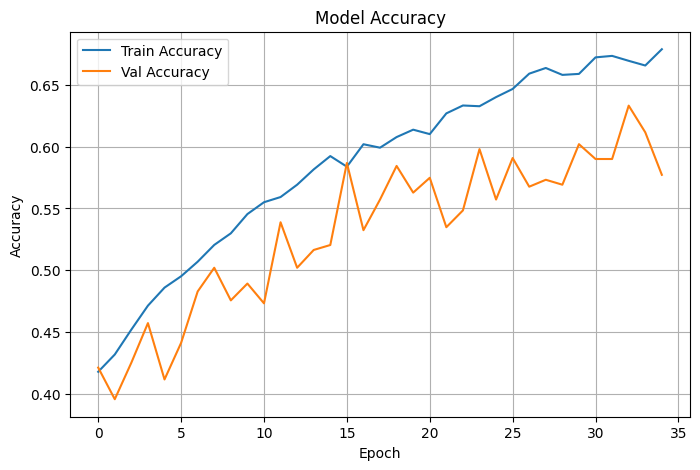

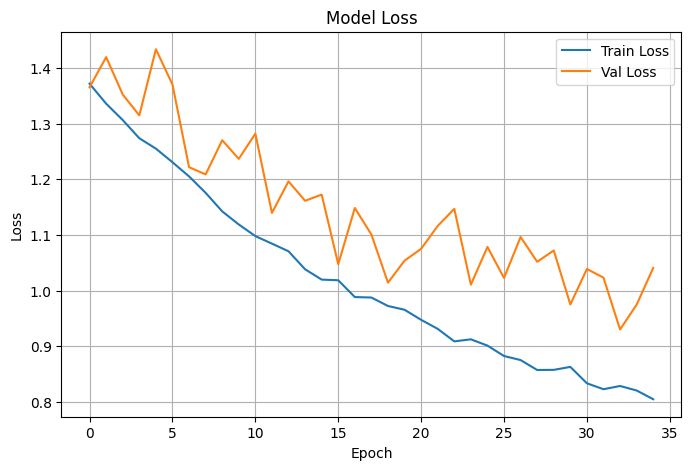

In [55]:
import matplotlib.pyplot as plt
import os

# Create a folder in your Google Drive
save_path = '/content/drive/MyDrive/Smart Bridge project  /model2_training_plots'
os.makedirs(save_path, exist_ok=True)

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_path, 'accuracy_plot.png'))  # Save to Drive
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(save_path, 'loss_plot.png'))  # Save to Drive
plt.show()


In [56]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/content/drive/MyDrive/Smart Bridge project/Ship Classfication/input/train/Tankers/2778067.jpg',target_size=(224,224))
img = image.img_to_array(img)
img = img.reshape((1,img.shape[0],img.shape[1],img.shape[2]))
img = preprocess_input(img)

pred = model.predict(img)
pred = pred.flatten()
pred = list(pred)

m = max(pred)
val_dict = { 0:'Cargo',
            1 : 'Military',
            2 : 'Carrier',
            3 : 'Cruise',
            4  : 'Tankers'}
result = val_dict[pred.index(m)]
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
Tankers
